## get two cross-section measurements from HEPData and plot them

- e+ e- -> pi+ pi- BES-III 2016 https://www.hepdata.net/record/ins1385603

- e+ e- -> pi+ pi- CMD-2 2007 https://www.hepdata.net/record/ins728302

<!-- TEASER_END -->

In [1]:
from math import *
import re
from pprint import pprint
import urllib.request
from array import array
import json
import yaml
import itertools

import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TLegend
from ROOT import TGraph, TGraphErrors, TGraphAsymmErrors
from ROOT import gROOT, gBenchmark, gRandom, gSystem, gStyle, gPad

Welcome to JupyROOT 6.22/00


In [2]:
##
## iterator generator using outer product of two lists
## - first list is inner and second one is outer
## - also able to return nth elements of iterator
## - iterator never ends but folds
##
class iterprod2:
  def __init__(self, arr1, arr2):
    self.arr1, self.arr2 = arr1, arr2
  def __iter__(self):
    self.i1 = 0
    self.i2 = 0
    return self
  def __next__(self):
    rc1, rc2 = self.arr1[self.i1], self.arr2[self.i2]
    self.i1 = (self.i1 + 1) % len(self.arr1)
    if (self.i1 == 0):
      self.i2 = (self.i2 + 1) % len(self.arr2)
    return rc1, rc2
  def elem(self, n):
    ielem1 = n % len(self.arr1)
    ielem2 = (n // len(self.arr1)) % len(self.arr2)
    return self.arr1[ielem1], self.arr2[ielem2]
  def elem1(self, n):
    return self.elem(n)[0]
  def elem2(self, n):
    return self.elem(n)[1]

In [3]:
##
## iterator generator using two lists with simultaneous advancement
## - also able to return nth elements of iterator
## - iterator never ends but folds
##
class iterzip2:
  def __init__(self, arr1, arr2):
    self.arr1, self.arr2 = arr1, arr2
  def __iter__(self):
    self.i1 = 0
    self.i2 = 0
    return self
  def __next__(self):
    rc1, rc2 = self.arr1[self.i1], self.arr2[self.i2]
    self.i1 = (self.i1 + 1) % len(self.arr1)
    self.i2 = (self.i2 + 1) % len(self.arr2)
    return rc1, rc2
  def elem(self, n):
    ielem1 = n % len(self.arr1)
    ielem2 = n % len(self.arr2)
    return self.arr1[ielem1], self.arr2[ielem2]
  def elem1(self, n):
    return self.elem(n)[0]
  def elem2(self, n):
    return self.elem(n)[1]

In [4]:
##---Root colors in Rtypes.h
from ROOT import kWhite, kBlack, kGray, kRed, kGreen, kBlue, kYellow, kMagenta
from ROOT import kCyan, kOrange, kSpring, kTeal, kAzure, kViolet, kPink

##--- Root line styles
from ROOT import kSolid, kDashed, kDotted, kDashDotted

##--- Root marker styles
from ROOT import kFullCircle, kFullSquare, kFullTriangleUp, kFullTriangleDown, kFullStar, kFullDiamond
from ROOT import kFullCross, kFullThreeTriangles, kFullFourTrianglesX, kFullDoubleDiamond
from ROOT import kFullFourTrianglesPlus, kFullCrossX, kFourSquaresX, kFourSquaresPlus

##
## Root colors that are closest to R v4+ colors
##
R_v4_colors = [   1,  46,   8, 977, 227, 617, 1163,  15 ]
mpl_colors = [ 943,  95, 414, 895, 872,  28, 224,  14, 218, 1020 ]
root_base_colors = [ kBlue, kOrange-3, kGreen, kRed, kMagenta, kCyan, kBlack, kGray]
chosen_colors = root_base_colors

my_linestyles = [kSolid, kDashed, kDotted, kDashDotted]
my_markerstyles = [
  kFullCircle, kFullSquare, kFullTriangleUp, kFullTriangleDown, kFullStar, kFullDiamond,
  kFullCross, kFullThreeTriangles, kFullFourTrianglesX, kFullDoubleDiamond,
  kFullFourTrianglesPlus, kFullCrossX
]

##--- iterator to plot different measurements of same quantity on same plot
col_lstyle_gen = iterprod2(chosen_colors, my_linestyles)
col_lstyle_iter = iter(col_lstyle_gen)

##--- iterator to plot different measurements of same quantity on same plot
mstyle_col_gen = iterzip2(my_markerstyles, chosen_colors)
mstyle_col_iter = iter(mstyle_col_gen)

In [5]:
##
## functions and defs
##

In [6]:
def json_load_url(url):
  return json.load(urllib.request.urlopen(url))

def yaml_load_url(url):
  return yaml.safe_load(urllib.request.urlopen(url))

In [7]:
##
## get symmetric unc
## if multiple unc are present, get quadratic sum
## handle case when unc is specified as percent of value
##
def get_symm_unc(uncvec, yval=0):
  vvar = 0
  for cunc in uncvec:
    vunc = cunc["symerror"]
    if (type(vunc) in (int, float)):
      vvar += cunc["symerror"]**2
    else:
      ##--- handle syst unc defined as percent of yval
      ## rc = re.match(r"^([^%]*)%$", vunc)
      rc = get_symm_unc.re_percunc.match(vunc)
      if (rc != None):
        vunc = float(rc.groups()[0])
        vvar += (vunc/100 * yval)**2
  return sqrt(vvar)
##--- precompile regexp
get_symm_unc.re_percunc = re.compile(r"^([^%]*)%$")

In [8]:
##
## code
##

In [9]:
canvas = TCanvas("canvas", "canvas", 800, 600)
gPad.SetTopMargin(0.10)
gPad.SetBottomMargin(0.10)
gPad.SetLeftMargin(0.10)
gPad.SetRightMargin(0.10)

In [10]:
##
## get BES-III measurement
##
ins1385603_entry = json_load_url("https://www.hepdata.net/record/ins1385603?format=json")
print("Last updated: ", ins1385603_entry["record"]["last_updated"])
pprint(ins1385603_entry)

Last updated:  Mon, 05 Oct 2020 13:49:56 GMT
{'access_count': {'sum': 925},
 'additional_resources': True,
 'breadcrumb_text': 'Ablikim, M. et al.',
 'coordinator': 3,
 'data_tables': [{'data': {'csv': 'https://www.hepdata.net/download/table/ins1385603/Table1/csv',
                           'json': 'https://www.hepdata.net/download/table/ins1385603/Table1/json',
                           'root': 'https://www.hepdata.net/download/table/ins1385603/Table1/root',
                           'yaml': 'https://www.hepdata.net/download/table/ins1385603/Table1/yaml',
                           'yoda': 'https://www.hepdata.net/download/table/ins1385603/Table1/yoda'},
                  'description': 'Results for the bare cross section '
                                 '$\\sigma^\\text{bare}_{\\pi^+\\pi^-}$ and '
                                 'the pion form factor together with their '
                                 'statistical uncertainties. The systematical '
                           

In [11]:
##
## get CMD-2 measurement
##
ins728302_entry = json_load_url("https://www.hepdata.net/record/ins728302?format=json")
print("Last updated: ", ins728302_entry["record"]["last_updated"])
pprint(ins728302_entry)

Last updated:  Tue, 10 Oct 2006 00:00:00 GMT
{'access_count': {'sum': 971},
 'additional_resources': True,
 'breadcrumb_text': 'Akhmetshin, R.R. et al.',
 'coordinator': 1,
 'data_tables': [{'data': {'csv': 'https://www.hepdata.net/download/table/ins728302/Table1/csv',
                           'json': 'https://www.hepdata.net/download/table/ins728302/Table1/json',
                           'root': 'https://www.hepdata.net/download/table/ins728302/Table1/root',
                           'yaml': 'https://www.hepdata.net/download/table/ins728302/Table1/yaml',
                           'yoda': 'https://www.hepdata.net/download/table/ins728302/Table1/yoda'},
                  'description': 'Measured values of the pion form factor. The '
                                 'errors are statistical only.',
                  'doi': '10.17182/hepdata.41782.v1/t1',
                  'id': 35960,
                  'location': 'Data from T 2,F 9',
                  'messages': False,
           

In [12]:
gStyle.SetOptStat(0)
basehist = TH1F("basehist", "|F_{#pi}|^{2}", 100, 0.5, 1)
basehist.SetMinimum(0)
basehist.SetMaximum(55)
basehist.GetXaxis().SetTitle("#sqrt{s} [GeV]")
basehist.GetYaxis().SetTitle("|F_{#pi}|^{2}")

basehist.Draw("")
## canvas.Draw()

In [13]:
##
## get YAML of first item of the submission
##
ins1385603_Table1 = yaml_load_url(ins1385603_entry["data_tables"][0]["data"]["yaml"])

##
## independent variable
##
xval = array('f')
for ielem, delem in enumerate(ins1385603_Table1["independent_variables"][0]["values"]):
  xval.append(delem["value"]/1000)

##
## 2nd dependent variable, pion form factor
##
yval = array('f')
yunc = array('f')
for ielem, delem in enumerate(ins1385603_Table1["dependent_variables"][1]["values"]):
  yvalcurr = delem["value"]
  yval.append(yvalcurr)
  yunc.append(get_symm_unc(delem["errors"], yvalcurr))

##
## TGraphErrors
##
ins1385603_gr = TGraphErrors(len(xval), xval, yval, 0, yunc)
title = "-".join(ins1385603_entry["record"]["collaborations"])
title += " " + ins1385603_entry["record"]["year"]
ins1385603_gr.SetTitle(title)
mstyle, col = next(mstyle_col_iter)
ins1385603_gr.SetMarkerStyle( mstyle )
ins1385603_gr.SetLineColor( col )
ins1385603_gr.SetMarkerColor( col )

ins1385603_gr.Draw("epsame")
## canvas.Draw()

In [14]:
##
## get YAML of first item of the submission
##
ins728302_Table1 = yaml_load_url(ins728302_entry["data_tables"][0]["data"]["yaml"])

##
## independent variable
##
xval = array('f')
for ielem, delem in enumerate(ins728302_Table1["independent_variables"][0]["values"]):
  xval.append(delem["value"]/1000)

##
## 1st dependent variable, pion form factor
##
yval = array('f')
yunc = array('f')
for ielem, delem in enumerate(ins728302_Table1["dependent_variables"][0]["values"]):
  yvalcurr = delem["value"]
  yval.append(yvalcurr)
  yunc.append(get_symm_unc(delem["errors"], yvalcurr))

##
## TGraphErrors
##
ins728302_gr = TGraphErrors(len(xval), xval, yval, 0, yunc)
title = "-".join(ins728302_entry["record"]["collaborations"])
title += " " + ins728302_entry["record"]["year"]
ins728302_gr.SetTitle(title)
mstyle, col = next(mstyle_col_iter)
ins728302_gr.SetMarkerStyle( mstyle )
ins728302_gr.SetLineColor( col )
ins728302_gr.SetMarkerColor( col )

ins728302_gr.Draw("epsame")
## canvas.Draw()

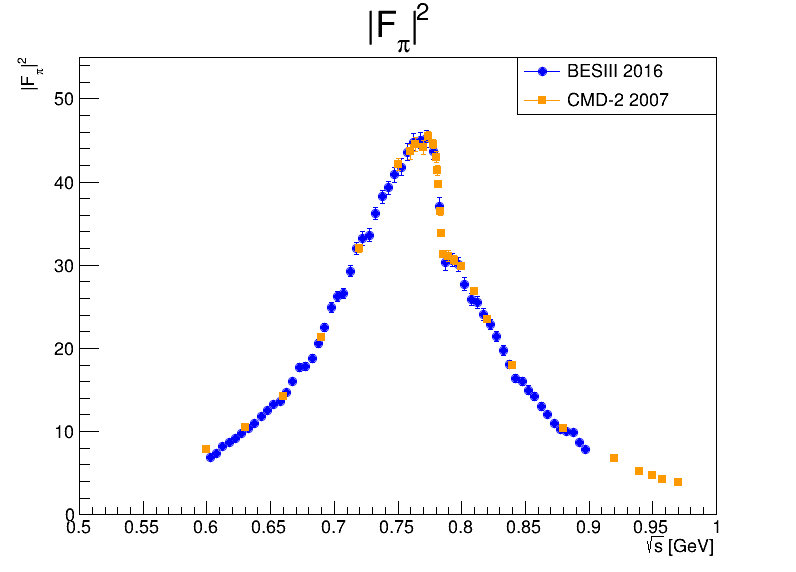

In [15]:
leg = TLegend(0.65, 0.80, 0.90, 0.90)
leg.SetTextSize(0.035)
leg.AddEntry(ins1385603_gr, ins1385603_gr.GetTitle(), "LP")
leg.AddEntry(ins728302_gr, ins728302_gr.GetTitle(), "LP")
leg.Draw()
canvas.Draw()

In [16]:
rfile = TFile("precsm-resp-plot-example.root", "recreate")
canvas.Write("F_pip_pim")
rfile.Close()